In [1]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
import seaborn as sns
from rdkit.Chem import CanonSmiles
from tqdm.auto import tqdm

sns.set(context="talk", style="ticks", color_codes=True, rc={"legend.frameon": False})

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 24})


logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog("rdApp.error")
tqdm.pandas()

%matplotlib inline

In [3]:
data = pd.read_csv("CCO_CCOCC.csv")
data = data[~data.No.isin([48, 199, 1155, 517, 518, 931])]

In [4]:
data = data[data["Mole/Weight/Volume Fraction"] == "mole"]

In [5]:
blends = data[
    [
        "No",
        "Mole/Weight/Volume Fraction",
        "CN",
        "DCN or ICN",
        "Method",
        "Device",
        "Comments",
        "Reference",
    ]
]

blends = blends.set_index("No")

In [6]:
blends["Mole/Weight/Volume Fraction"].value_counts()

mole    12
Name: Mole/Weight/Volume Fraction, dtype: int64

In [7]:
smiles = data.melt(
    id_vars="No",
    value_vars=data.columns[data.columns.str.startswith("smi_mol")],
    value_name="SMILES",
)
m_conc = data.melt(
    id_vars="No",
    value_vars=data.columns[data.columns.str.startswith("x_mol")],
    value_name="mol_pct",
)


def try_canon_smiles(x):
    try:
        return CanonSmiles(x)
    except Exception:
        return None


smiles["SMILES"] = smiles.SMILES.apply(try_canon_smiles)
smiles["mol_pct"] = m_conc["mol_pct"]
fuel_comp = smiles.drop("variable", axis=1)

In [8]:
fuel_comp = (
    fuel_comp.dropna()
    .sort_values(["No", "mol_pct"], ascending=[True, False])
    .reset_index(drop=True)
)

# Drop a few more problematic mixtures
mol_closure = fuel_comp.groupby("No").sum().mol_pct
fuel_comp = fuel_comp[~fuel_comp.No.isin(mol_closure[mol_closure < 0.99].index)]

assert np.allclose(fuel_comp.groupby("No").sum(), 1.0, atol=0.01)
fuel_comp.head()

,No,SMILES,mol_pct
0,505,CCO,0.941
1,505,CCOCC,0.059
2,506,CCO,0.877
3,506,CCOCC,0.123
4,507,CCO,0.842


In [9]:
np.array(fuel_comp)

array([[505, 'CCO', 0.941],
       [505, 'CCOCC', 0.059],
       [506, 'CCO', 0.877],
       [506, 'CCOCC', 0.123],
       [507, 'CCO', 0.842],
       [507, 'CCOCC', 0.158],
       [508, 'CCO', 0.806],
       [508, 'CCOCC', 0.194],
       [509, 'CCO', 0.768],
       [509, 'CCOCC', 0.232],
       [510, 'CCO', 0.728],
       [510, 'CCOCC', 0.272],
       [511, 'CCO', 0.64],
       [511, 'CCOCC', 0.36],
       [512, 'CCO', 0.543],
       [512, 'CCOCC', 0.457],
       [513, 'CCOCC', 0.567],
       [513, 'CCO', 0.433],
       [514, 'CCOCC', 0.628],
       [514, 'CCO', 0.372],
       [515, 'CCOCC', 0.692],
       [515, 'CCO', 0.308],
       [516, 'CCOCC', 0.835],
       [516, 'CCO', 0.165]], dtype=object)

In [10]:
len(fuel_comp.SMILES.unique())

2

In [11]:
X = fuel_comp.pivot(columns="SMILES", index="No", values="mol_pct").fillna(0.0)
print(X.shape)
print(tf.convert_to_tensor(X).shape)
blends = blends.reindex(X.index)
y = blends.CN

(12, 2)
(12, 2)


2023-04-20 14:03:19.977217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
X

SMILES,CCO,CCOCC
No,,
505,0.941,0.059
506,0.877,0.123
507,0.842,0.158
508,0.806,0.194
509,0.768,0.232
510,0.728,0.272
511,0.640,0.360
512,0.543,0.457
513,0.433,0.567


In [13]:
np.array(blends.CN)

array([ 7.8,  8.2,  9.2, 10.5, 11. , 16.9, 23.8, 35.5, 48.9, 56.6, 67.9,
       97.7])

In [14]:
import sklearn
from sklearn.linear_model import LinearRegression

In [15]:
reg = LinearRegression(fit_intercept=False).fit(X, y)

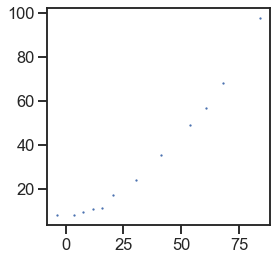

In [16]:
plt.figure(figsize=(4, 4))
plt.plot(reg.predict(X), y, ".", ms=2.5)

In [17]:
blends["reg_err"] = reg.predict(X) - y

In [18]:
sklearn.metrics.mean_absolute_error(reg.predict(X), y)

5.2047781279340795

In [19]:
reg.coef_, reg.intercept_

(array([-10.30663426, 102.79793447]), 0.0)

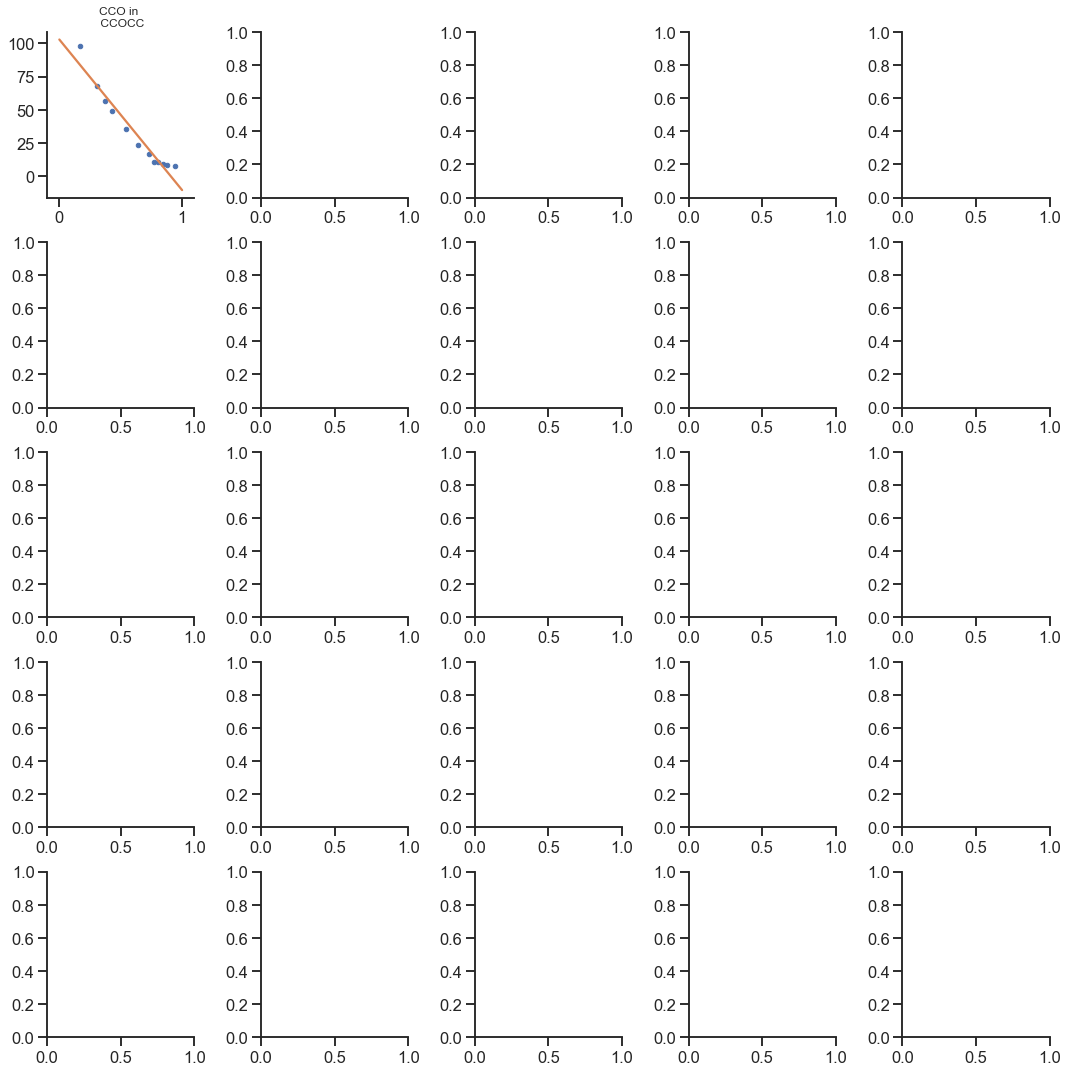

In [20]:
blends["components"] = fuel_comp.groupby("No").apply(
    lambda df: tuple(sorted(df.SMILES))
)

num_comps = fuel_comp.No.value_counts()
pure_comps = blends[blends.index.isin(num_comps[num_comps == 1].index)].copy()
pure_comps['smiles'] = pure_comps.components.apply(lambda x: x[0])
pure_comps = pure_comps.set_index('smiles')


binary_blends = blends[blends.components.apply(len) == 2].components.value_counts()


fig, axmatrix = plt.subplots(nrows=5, ncols=5, figsize=(15, 15))

for smiles, ax in zip(binary_blends[binary_blends >= 3].index, axmatrix.flatten()):
    
    df = (
        blends[blends.components == smiles]
        .merge(fuel_comp[fuel_comp.SMILES == smiles[0]], right_on="No", left_index=True)
        .sort_values("mol_pct")
    )
    
    ax.set_title(f"{smiles[0]} in \n {smiles[1]}", fontsize=12)
    
    ax.plot(df.mol_pct, df.CN, ".")
    
    xs = np.linspace(0, 1, num=50)
    X_reg = pd.DataFrame(np.zeros((X.shape[1], len(xs))), index=X.columns)
    X_reg[X.columns == smiles[0]] = xs
    X_reg[X.columns == smiles[1]] = 1 - xs
    
    ax.plot(xs, reg.predict(X_reg.T), '-')
    
    if smiles[0] in pure_comps.index:
        ax.plot(1, pure_comps.loc[smiles[0], 'CN'], "o", color='b')
        
    
    if smiles[1] in pure_comps.index:
        ax.plot(0, pure_comps.loc[smiles[1], 'CN'], "o", color='b')
        
    
    ax.set_xlim([-.1, 1.1])
    
sns.despine()
plt.tight_layout()

# Model for CN regression considering blend effects

$$CN = \sum_i X_i CN_i$$
$$CN_i = X W$$

Here, we assume that cetane number is determined by the linear (molar) combination of each component's blending cetane number, and that the blending cetane number is composition-dependent. We further assume that blending a component's cetane number is specified by $ x_j^T w_j $, where $x_j$ is the concentration of a given component in the blend, and $w_j$ is the blending cetane number of the current component *at infinite dilution* in component $j$. (When $i = j$, i.e., the diagonal of matrix $W$, it is the pure-component cetane number.

This assumes that blending cetane number can be described by a linear model; and for a binary blend, that the blending cetane number varies linearly between the pure-component cetane number and some infinite-dilution cetane number.


In [21]:
from cn_model import CNModel

2023-04-20 14:03:22.457352: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


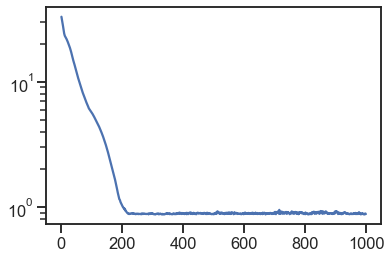

In [22]:
m = CNModel()
m.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(learning_rate=1.))
hist = m.fit(X, y, batch_size=len(X), epochs=1000, verbose=0)
plt.semilogy(hist.history['loss'])

In [23]:
hist.history['loss'][-1]

0.8827858567237854

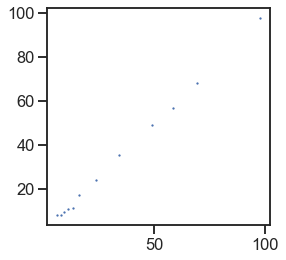

In [24]:
plt.figure(figsize=(4, 4))
plt.plot(m(tf.convert_to_tensor(X)), y, ".", ms=2.5)

It might be worth looking in more detail at some of these outliers -- there's no validation data here yet, I'm just trying to find a model structure that fits the data well. These points would violate the assumptions I laid out above, and might either be odd chemistry or an experimental / database error

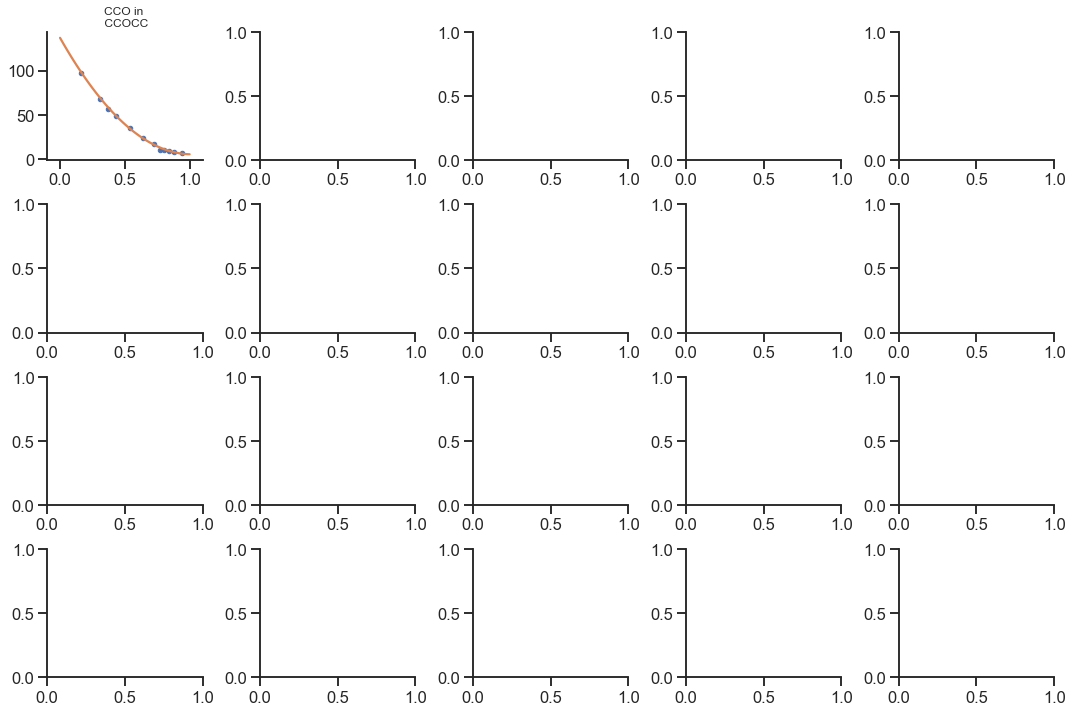

In [25]:
fig, axmatrix = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))

for smiles, ax in zip(binary_blends[binary_blends >= 5].index, axmatrix.flatten()):
    
    df = (
        blends[blends.components == smiles]
        .merge(fuel_comp[fuel_comp.SMILES == smiles[0]], right_on="No", left_index=True)
        .sort_values("mol_pct")
    )
    
    ax.set_title(f"{smiles[0]} in \n {smiles[1]}", fontsize=12)
    
    ax.plot(df.mol_pct, df.CN, ".")
    
    xs = np.linspace(0, 1, num=50)
    X_reg = pd.DataFrame(np.zeros((X.shape[1], len(xs)), dtype=np.float64), index=X.columns)
    X_reg[X.columns == smiles[0]] = xs
    X_reg[X.columns == smiles[1]] = 1 - xs
    
    ax.plot(xs, m(tf.convert_to_tensor(X_reg.T)), '-')
    
    if smiles[0] in pure_comps.index:
        ax.plot(1, pure_comps.loc[smiles[0], 'CN'], "o", color='b')
        
    
    if smiles[1] in pure_comps.index:
        ax.plot(0, pure_comps.loc[smiles[1], 'CN'], "o", color='b')
        
    
    ax.set_xlim([-.1, 1.1])
    
sns.despine()
plt.tight_layout()

In [26]:
# These are the estimated pure-component cetane numbers
m1_cetane_numbers = pd.Series(np.diag(m.W.numpy()), index=X.columns)
m1_cetane_numbers

SMILES
CCO        5.837499
CCOCC    136.804611
dtype: float32

# W demo - ethanol-diethyl ether example (YJ)

In [28]:
list(fuel_comp.SMILES.unique()).index('CCO'), list(fuel_comp.SMILES.unique()).index('CCOCC')

(0, 1)

In [29]:
m.W.numpy()

array([[  5.8374987,   8.108216 ],
       [  7.841067 , 136.80461  ]], dtype=float32)

In [30]:
data[(data.smi_mol1 == 'CCO') & (data.smi_mol2 == 'CCOCC') & (data.smi_mol3.isna())][['x_mol_1',
                                                                                      'x_mol_2',
                                                                                      'CN']]

,x_mol_1,x_mol_2,CN
0,0.941,0.059,7.8
1,0.877,0.123,8.2
2,0.842,0.158,9.2
3,0.806,0.194,10.5
4,0.768,0.232,11.0
5,0.728,0.272,16.9
6,0.640,0.360,23.8
7,0.543,0.457,35.5
8,0.433,0.567,48.9
9,0.372,0.628,56.6


In [31]:
data[(data.smi_mol1 == 'CCO') & (data.smi_mol2 == 'CCOCC') & (data.smi_mol3.isna())][['x_mol_1',
                                                                                      'x_mol_2',
                                                                                      'CN']].to_csv('cco_ccocc_test.csv', index=False)

<AxesSubplot:>

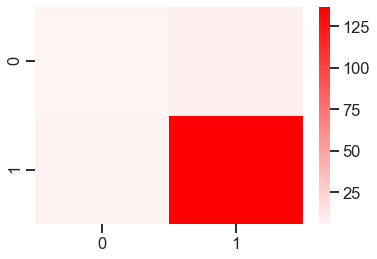

In [32]:
# For this regression, most of the off-diagonal coefficients are zero, since we don't have data for those blends
sns.heatmap(m.W.numpy(), cmap='bwr', center=0)